[View in Colaboratory](https://colab.research.google.com/github/estoilkov/machine-learning-project-walkthrough/blob/master/MeanReversionTutorial_2_j.ipynb)

# Mean Reversion: How to find it?

Paraphrasing Peter Drucker's *"you can't manage what you can't measure"*:
## If you can't test, you can't find it ... 

Before finding out how to find the signals in the whole financial spectrum, it would help to know what available tests are out there to identify whether a signal is mean reverting or not.

In the previous [post](https://www.markov.finance/single-post/2018/03/20/Educational-Series-Mean-Reversion) I introduced the OU and the AR(1) processes. Remember, AR(1) uses assumptions that simplify the math required to solve the equations. While we have not used AR(1) to calibrate the mean reverting parameters of a (suspected) mean reverting series, most of the tests available in the open source universe deal with AR(1) processes, like:
* Hurst exponent,
* Augmented Dickey-Fuller test,
I do not want to rewrite the explanation, as you can find it in [Basics of Statistical Mean Reversion Testing](https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing) [BSMRT], but just for fun I will apply it to our USD 2-5-10 example instead of the typical Google/Apple pairs.

**Warning:** Blindly using statistics can be harmful for your health. Most statistics come with a list of side effects that appear when the 'small print' in the label is ignored. My goal in the following lines is to use them to help us find mean reverting signals, but only as a part of more fundamental analysis. If you use them without an existing background you might end up in the land of [spurious correlations](http://www.tylervigen.com/spurious-correlations) where per capita consumption of chicken correlates with total US crude imports. Statistics tests have strong assumption on the input data which you should be aware (if you were looking for a fully non-human intervention method). For starters, all the tests below assume AR(1) time series - meaning the $\Delta t$ between data points is constant, but we are using time series with business days where some data points have a $\Delta t$ of 3 days instead of 1 day.

Below, I load the whole term structure os US rates, and then compute the 2-5-10 fly with 50/50 weights: 



In [0]:
#@title Default title text
# -*- coding: utf-8 -*-

# In this section I add the initial libraries required for this tutorial
# 'requests': allow HTTP-post API calls
import requests
# 'json':     to format as json calls to API
import json 
# 'pandas':   to plot the timeseries
import pandas as pd
# 'datetime': to convert different date formats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

# defining the api-endpoint 
#API_ENDPOINT = "https://markovsimulator.azurewebsites.net/api/MarkovCalibrator_01?code=UFYL9CcFRERnVbZJ3ELdRRY7u59vD3BgONzaGLNEOekTfKf0Ug9Bfw=="
API_ENDPOINT = "https://gmaatest.azurewebsites.net/api/HttpTriggerCSharp1?code=COXmk9ou6Mr8/dUCYj045SaeNm6jCkPzJ3ilU/dCiTvNcFNQax4BMQ=="

# Treasury rates: we can download them from Quandl
QUAND_TS = "https://www.quandl.com/api/v3/datasets/USTREASURY/YIELD.json?api_key=o6YKGjyDcseE3LFKrSK3"


# Call Quandl to get all the data
q = requests.get(url = QUAND_TS)
q_json = q.json() 
q_data = q_json['dataset']['data']

# Compute derived series from Quandl Data
dates = []
values = []
q_len = len(q_data)
column_len = len(q_data[0])
column = column_len-1
columns = q_json['dataset']['column_names']
#print (columns)


# The following could be easily done using Quandl's
# python API - but I keep it the 'hard way' to allow
# compatibility with Google Colaboratory
df_rates = pd.DataFrame.from_records(q_data, columns = columns)
df_rates['Date'] = pd.to_datetime(df_rates['Date'])
df_rates.set_index('Date', inplace=True)
#df_rates.plot()


       0
2 YR  -1
5 YR   2
10 YR -1


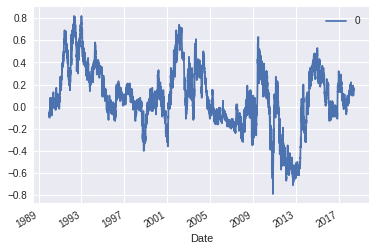

In [2]:



# columns names: ["Date","1 MO","3 MO","6 MO","1 YR","2 YR","3 YR","5 YR","7 YR","10 YR","20 YR","30 YR"]
# as the index start from 0, columns 2,5 and 10 are:
cols = [5, 7, 9]

columns_fly = [columns[i] for i in cols]
TimeSeries = df_rates[columns_fly]

# I use this line to keep each weight linked to the name of the maturity
Weights = pd.DataFrame([-1, 2, -1], index = TimeSeries.columns)
print (Weights)

# Now all I have to is the 'dot' product of Weights and TimeSeries
butterfly_ts = (TimeSeries.dot(Weights)).dropna()
butterfly_ts.plot()


### Hurst exponent in practice
I'll quote from the [[BSMRT]](https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing) blog I mentioned:


> A time series can then be characterised in the following manner:
* $H<0.5H<0.5$ - The time series is mean reverting
* $H=0.5H=0.5$ - The time series is a Geometric Brownian Motion
* $H>0.5H>0.5$ - The time series is trending

>In addition to characterisation of the time series the Hurst Exponent also describes the extent to which a series behaves in the manner categorised. For instance, a value of HH near 0 is a highly mean reverting series, while for HH near 1 the series is strongly trending.


Lets compute the Hurst parameters with python:


In [3]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

def hurst(ts):
	"""Returns the Hurst Exponent of the time series vector ts"""
	# Create the range of lag values
	lags = range(2, 100)

	# Calculate the array of the variances of the lagged differences
	tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

	# Use a linear fit to estimate the Hurst Exponent
	poly = polyfit(log(lags), log(tau), 1)

	# Return the Hurst exponent from the polyfit output
	return poly[0]*2.0

print (hurst(butterfly_ts))

[0.43670626]


when I computed the result it was 0.43688, less than 0.5, and indicating the signal is mean reverting. However, it does not seem to be _very_ mean reverting as we would have preferred for it to be closer to 0. 

### Augmented Dickey-Fuller in practice


In [4]:
# Import the Time Series library
import statsmodels.tsa.stattools as ts

# Import Datetime
from datetime import datetime

# Output the results of the Augmented Dickey-Fuller test for Google
# with a lag order value of 1
print (ts.adfuller(butterfly_ts[0], 1))


(-4.2472975794099765, 0.000547416540345047, 1, 7096, {'5%': -2.8619473981777572, '1%': -3.4312718809379334, '10%': -2.5669868539820775}, -28994.736676103945)


/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The first value is the calculated test-statistic, while the second value is the p-value. The fourth is the number of data points in the sample. The fifth value, the dictionary, contains the critical values of the test-statistic at the 1, 5 and 10 percent values respectively. At the time when I computed the test, the calculated test-statistic was -4.2298 which was less that the 1% critical value of -3.4313 (and less that the critical values at 5% and 10%), indicating the the butterfly 2-5-10 is mean reverting (although students of Statistics might argue that the test rejected the hypothesis that the Time Series is a random walk). The p-value corresponding to the test was 0.058% - so well below the 5% probability threshold usually considered as signal that the time series could be non mean reverting. Read [What is the meaning of p values and t values](https://stats.stackexchange.com/questions/31/what-is-the-meaning-of-p-values-and-t-values-in-statistical-tests) if you need refreshing your memory.

While Statisticians might debate the merits of the tests, they provide some basis for us to go beyond the accumulated market memory of mean reverting signals.


## How can I find Mean Reverting tradeable signals ?

We could find some asset classes that are mean reverting by nature (some FX crosses like AUD/NZD for some periods of time), but the opportunity set increases when we can enter in linear combinations of asset classes, or portfolios of long/short assets that we can enter and exit over a period of time (without rebalancing - to minimize transaction costs).

### Pairs trading
The internet is already littered with examples of pairs trading (taking a couple of assets and finding if buying one versus selling the other weighted by a certain hedge ratio results in a mean reverting strategy), so instead of writing another example please read:
* [Identifying Asset Pairs for Pairs Trading](http://hkopp.github.io/2017/07/identifying-asset-pairs-for-pairs-trading) - were the basic recipe of magically finding two stocks, do a linear regression on them to find the hedge ratio and test for mean reversion (as above) is explained, counterbalanced by 
* [Why I won't teach pair trading to my students](https://www.marketwatch.com/story/why-i-wont-teach-pair-trading-to-my-students-2012-10-01) (with real cases of blow-ups and a reminder never to forget the fundamental drivers which should drive the mean reversion),

The basic recipe of using linear regressions to identify the hedge ratio suffers from the fact that the ratio will differ depending on which asset class is used as the explanatory variable (see [Effect of switching response and explanatory variable in simple linear regression](https://stats.stackexchange.com/questions/20553/effect-of-switching-response-and-explanatory-variable-in-simple-linear-regressio) - it turns our the formulas give different results unless all the points are exactly on the line~) annoys all the practictioners trying to find the correct ratio.

('wings adfuller p-value:', 0.9091249800366502)
('body adfuller p-value:', 0.8583858294638854)
if both the above p-values are > than 5% the series are not mean reverting
and can be used in the cointegration test
('Wings as explanatory variable have a beta_w of ', 1.0217157779654704)
('Body as explanatory variable have a beta_b of ', 0.9864733462355418)
('and beta_w is not the inverse of the beta_b:  ', 1.0137121330404688)


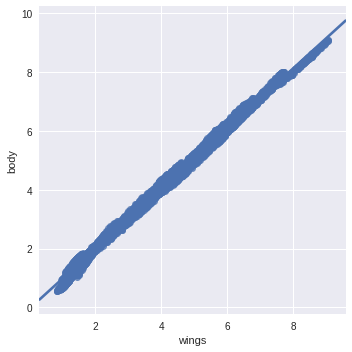

In [5]:

wings_body = butterfly_ts.copy()


# A common practicioner trick is to express the mean reverting signal as
# a scatter of two spreads.

# We start with the 'wings', which is just the average of the outlying 
# maturities (2y and 10y)
wings_body['wings'] = (TimeSeries.dot([0.5, 0, 0.5]))
# the fine line: the cointegration test requires the underlying time series
# to be non-meanreverting, so we test them using adf.
print ('wings adfuller p-value:',ts.adfuller(wings_body['wings'], 1)[1])
# versus the body (5y)
wings_body['body'] = (TimeSeries.dot([0, 1, 0]))
print ('body adfuller p-value:',ts.adfuller(wings_body['body'], 1)[1])
print ('if both the above p-values are > than 5% the series are not mean reverting')
print ('and can be used in the cointegration test')
# To plot the scatter with a line:
import seaborn as sns
sns.lmplot(x='wings',y='body',data=wings_body,fit_reg=True) 
#wings_body.plot(x = 'wings', y ='body', kind = 'scatter')

import statsmodels.api as sm # import statsmodels 

X = wings_body["wings"] ## X usually means our input variables (or independent variables)
y = wings_body["body"] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## Intercept the model

# body = beta_w * wings + constant_w
model_yX = sm.OLS(y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
print ("Wings as explanatory variable have a beta_w of ", model_yX.params[1])

# wings = beta_b * body + constant_b
# Note the difference in argument order
model_Xy = sm.OLS(X, y).fit() ## sm.OLS(output, input)

# Print out the statistics
print ("Body as explanatory variable have a beta_b of ", model_Xy.params[1][0])
print ("and beta_w is not the inverse of the beta_b:  ", 1 / model_Xy.params[1][0])

Here is where Statisticians introduced the concept of [cointegration](https://en.wikipedia.org/wiki/Cointegration) which a soothingly complicated name to say that if you can get a mean reverting series by linearly combining other series then you can call them cointegrated. The small print: the series have to be [Integrated of Order 1 I(1)](https://en.wikipedia.org/wiki/Order_of_integration) but luckily the ADF test checks for that. Some practicioners might skip this test (as it is not readily available in Excel or Bloomberg) and will 'visually' inspect the timeseries - if they look 'trending' then they will assume they are I(1).

When you compare only two series, you can combine the linear regression plot + ADF test and call it [Engle Granger two step](https://en.wikipedia.org/wiki/Cointegration#Engle%E2%80%93Granger_two-step_method).



### Using PCA

As we saw above, linear regression can give slightly (or in some cases, big) hedge ratios (in cointegration you do not define one explanatory variable but use the set as a cointegrated set).

That is why some practitioners have chosen the Principal Component Analysis (PCA) methods (as it is symmetrical) - the hedge ratio results are more 'intuitive' (as they do not depend on which asset you put first). 

Once PCA was found for pairs trading hedge ratios, it was normal that people would apply it to multiple simultaneous assets (like the term structure of rates!). 

I will briefly mention how PCA is used by some traders, but keep in mind that there is a 'proper' method (the [Johansen test](https://en.wikipedia.org/wiki/Johansen_test)) finely tuned to test for mean reversion of linear combinations of Time Series - I will explain it later on.

For two assets, the PCA method which gives a linear fit solution that is symmetrical is

In [6]:
import numpy as np

wings_body_pca = wings_body[['body', 'wings']]

# Demean the time series (we only want the 'hedge ratio')
TS = wings_body_pca - wings_body_pca.mean()

# Trick: compute the covariance matrix on the levels
# by doing this we are finding the linear combination which 
# return the signal with the lowest variance.
# Many Statisticians would be horrified, as we are not doing 
# it on vectors of Normal Distribution. More on this later,
# but it turns out this method fits a line with 
# symmetric errors.
TScov = TS.cov()
eig_val_sc, eig_vec_sc = np.linalg.eig(TScov)
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_sc[i]), eig_vec_sc[:,i]) for i in range(len(eig_val_sc))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Select the eigenvector with the lowest eigenvalue
# which corresponds to a signal with low variance
eig_2 = eig_pairs[1][1]

print ("beta_pca :",eig_2/np.min(eig_2))

('beta_pca :', array([ 1.        , -1.02368157]))


The 'symmetric' hedge ratio of 1.0238 is quite similar to the ones above, but at least does not bring uncertainty. 

Think of PCA as a method to find the axis of an ellipsoid that can fit the data (read [Wikipedia PCA](https://en.wikipedia.org/wiki/Principal_component_analysis#Intuition)) - it will work even if the data does not have a linear relationship and we can choose the axis (or 'eigenvector') with the lowest associated variance as a mean reverting candidate.

Once the method was derived, it was not long before someone thought that the PCA could be extended to many assets. Instead of arbitrarily using the average of the rates they decided to use it for 3 (or even more) assets...

('PCA Weights :', array([-0.83518678,  2.        , -1.25708147]))
(-5.08210730611698, 1.5228083481505643e-05, 1, 7096, {'5%': -2.8619473981777572, '1%': -3.4312718809379334, '10%': -2.5669868539820775}, -30116.630501359672)


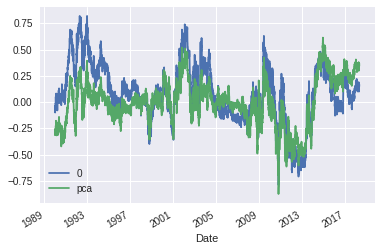

In [7]:


# Demean the time series (we only want the 'hedge ratio')
TS = TimeSeries - TimeSeries.mean()
TScov = TS.cov()
eig_val_sc, eig_vec_sc = np.linalg.eig(TScov)
eig_pairs = [(np.abs(eig_val_sc[i]), eig_vec_sc[:,i]) for i in range(len(eig_val_sc))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Select the eigenvector with the lowest eigenvalue
# which corresponds to a signal with low variance
eig_3 = eig_pairs[2][1]

# I normalize by the middle weights (5yr) and 
# multiply by 2
pca_weights = 2 * eig_3/eig_3[1]
print ("PCA Weights :",pca_weights)
butterfly_ts['pca'] = (TS.dot(pca_weights)).dropna()
butterfly_ts.plot()
print (ts.adfuller(butterfly_ts['pca'], 1))

... which does look even more mean reverting than the 50-50 butterfly (look how the t-statistic of -5.075 is even more negative than the one we found before). When I ran the code the weight results were assymetric: -0.83 for the 2yr weight and -1.26 for the 10yr, which is not standard for discretionary traders. In practice, traders would prefer simple and liquid strategies instead of adding complication for the sake of small improvements.

But a note of caution: while PCA seems to give nice mean reversion signals as result of the implicit variance minimization, it does not *assure* it will find them. Of course, we could marry PCA + the mean reversion test, but as it happens Econometricians derived the [Johansen Test](https://en.wikipedia.org/wiki/Johansen_test) as an all-in-one method that finds the mean reversion signals in multiple time series.

### The 'right way': Johansen Test

It is well beyond the purpose of this blog to explain how the Johansen Test works, please read [Johansen Test for Cointegatring Time Series Analysis](https://www.quantstart.com/articles/Johansen-Test-for-Cointegrating-Time-Series-Analysis-in-R) (or another academica literature). Furthermore, python does not include a common library (although you can use "pip install johansen" for one) which means the Google colaboratory does not support it. The below code might not work, so please take it with a pinch of salt, but when I ran it the test confirmed the presence of 1 linear relationship corresponding to weights [-0.8095,  2,         -1.2880] which were similar but not the same as the PCA weights found at the same time [-0.8323, 2, -1.2613] (remember, if you run this code you might get slightly different results as Quandl would have updated the time series).

The big difference is that the Johansen test was designed to find out and test all the possible linear combinations that yield mean reverting processes, while PCA (as used above) tries to find signals with low variance which may turn out to be mean reverting. 



In [8]:
!pip install johansen
from johansen import Johansen
#
x = TimeSeries.dropna().as_matrix()
x_centered = x - np.mean(x, axis=0)

# Because this library is not standard, you need to read
# the code itself to find out that
# significance_level = 2 means the test will use 99% confidence level,
# model = 2 means "This case should be used if
#            the input time series have linear trends but the cointegrating
#            relations are not expected to have linear trends."
johansen = Johansen(x_centered, model=2, significance_level=2)
eigenvectors, r = johansen.johansen()

# r will have the set of linear combinations that yield 
# mean reverting processes at confidence 99%
for i in r:
  vec = eigenvectors[:, i]
  vec_min = np.min(np.abs(vec))
  vec = 2 * vec / vec[1]

  print ("The",i,"th cointegrating relation: {}".format(vec))

  

  Running setup.py bdist_wheel for johansen ... - done
  Stored in directory: /content/.cache/pip/wheels/29/4a/ea/9a38d9ff2246e7a710488e8eaa22da457614a6f639979a59b4
Successfully built johansen
('The', 0, 'th cointegrating relation: [-0.80934929  2.         -1.28806607]')


### Bringing it all together

If you have read this so far, I recommend you read the following 'drain the lake to fish' approach to pair trading: [Efficient Pair Selection for Pair-Trading Strategies](https://www.maths.ox.ac.uk/system/files/attachments/593233.pdf) (but remember that you might get nasty surprises if you neglect the fundamental story).

In the [next post](https://colab.research.google.com/drive/1QNtBrFLsn7sqayEKgJVXg0UJz1JNYgVI) I will flesh out a ful example on the Term Structure of US rates to highlight the differences between PCA and the Johansen test in a case with multiple time series.